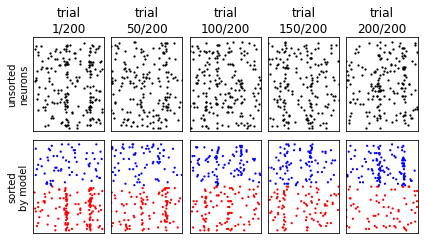

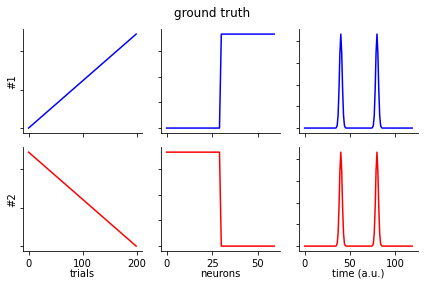

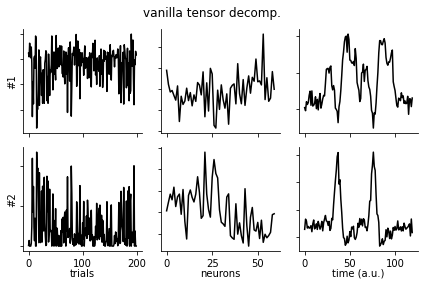

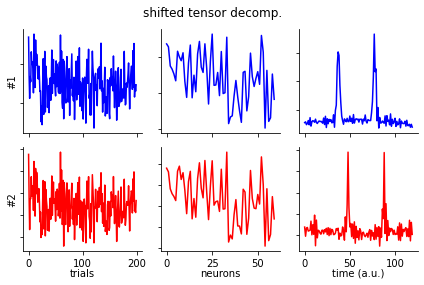

In [2]:
"""
This script generates Fig. 4 in Williams (2020). bioRxiv. 2020.03.02.974014
"""

from tensortools.cpwarp import ShiftedCP, fit_shifted_cp
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1234)

# Parameters defining synthetic dataset.
MAX_SHIFT = 0.15
N_TIMEBINS = 120
N_NEURONS = 60
N_TRIALS = 200
BACKGROUND_RATE = .02

# Create three low-dimensional factor matrices; rank-2 data tensor.
#
#    - neural_factors   : neurons x 2 
#    - trial_factors    : trials x 2 
#    - temporal_factors : timebins x 2
#
# See Williams et al. (2018) for the motivating application.
neural_factors = np.row_stack([
    np.repeat([0, 1], N_NEURONS // 2),
    np.repeat([1, 0], N_NEURONS // 2)
])

trial_factors = np.row_stack([
    np.linspace(0, 1, N_TRIALS),
    np.linspace(0, 1, N_TRIALS)[::-1],
])

temporal_factors = np.zeros((2, N_TIMEBINS))
temporal_factors[0][[40, 80]] = 1
temporal_factors[1][[40, 80]] = 1
temporal_factors = gaussian_filter1d(temporal_factors, 1.5, axis=1)

# Sample random shifts on each trial for each component.
rand_shifts = np.random.uniform(
    low=N_TIMEBINS * -MAX_SHIFT,
    high=N_TIMEBINS * MAX_SHIFT,
    size=(2, trial_factors.shape[1])
)

# Create `ShiftedCP` model representing ground truth.
_m = ShiftedCP(
    trial_factors,
    neural_factors,
    temporal_factors,
    u_s=rand_shifts  # shifts for axis=0
)

# Create (trials x neurons x timebins) tensor of firing rates.
spike_prob = _m.predict() + BACKGROUND_RATE

# Sample spikes from a Poisson distribution
data = np.random.poisson(spike_prob).astype(float)

# Shuffle the neuron indices.
shuff = np.random.permutation(data.shape[1])
data_shuff = data[:, shuff, :]

# === PLOT SPIKES === #
fig1, axes = plt.subplots(
    2, 5, sharey=True, sharex=True, figsize=(6, 3.5)
)

for k, axc in zip([0, 49, 99, 149, 199], axes.T):
    y, x = np.where(data_shuff[k])
    axc[0].set_title("trial\n{}/{}".format(k + 1, data.shape[0]))
    axc[0].scatter(x, y, s=5, lw=0, color="k")
    y, x = np.where(data[k])
    axc[1].scatter(x, y, s=5, lw=0, c=["b" if yi > 30 else "r" for yi in y])

axes[-1, -1].set_xlim([0, temporal_factors.shape[1]])
axes[-1, -1].set_ylim([-2, neural_factors.shape[1] + 2])
axes[0, 0].set_ylabel("unsorted\nneurons")
axes[1, 0].set_ylabel("sorted\nby model")

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

fig1.tight_layout()
fig1.subplots_adjust(wspace=.1, hspace=.1)

# === FIT TENSOR DECOMPOSITIONS === #
from tensortools.cpwarp import fit_shifted_cp

# Rank-2 classic tensor decomposition.
model1 = fit_shifted_cp(
    data, 2, boundary="wrap",
    n_restarts=5,
    max_shift_axis0=None,
    max_shift_axis1=1e-10, # essentially zero shift
    max_iter=100,
    u_nonneg=True,
    v_nonneg=True,
)

# Rank-2 decomposition with per-trial shifts.
model2 = fit_shifted_cp(
    data, 2, boundary="wrap",
    n_restarts=5,
    max_shift_axis0=MAX_SHIFT,
    max_shift_axis1=None,
    max_iter=100,
    u_nonneg=True,
    v_nonneg=True,
)

# Re-order the model factors to align with the ground truth.
if model2.factors[0][:,-1][0] < model2.factors[0][:,-1][1]:
    model2.permute([1, 0])


# === PLOT RESULTS === #

def plot_result(m, colors=("b", "r")):

    fig, axes = plt.subplots(2, 3, figsize=(6, 4))

    def normalize(f):
        return f / np.linalg.norm(f)

    axes[0, 0].plot(normalize(m.factors[0][0]), color=colors[0])
    axes[1, 0].plot(normalize(m.factors[0][1]), color=colors[1])

    axes[0, 1].plot(normalize(m.factors[1][0]), color=colors[0])
    axes[1, 1].plot(normalize(m.factors[1][1]), color=colors[1])

    axes[0, 2].plot(normalize(m.factors[2][0]), color=colors[0])
    axes[1, 2].plot(normalize(m.factors[2][1]), color=colors[1])

    for ax in axes[0]:
        ax.set_xticklabels([])

    for ax in axes.ravel():
        ax.set_yticklabels([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    axes[0, 0].set_ylabel("#1", labelpad=-1)
    axes[1, 0].set_ylabel("#2", labelpad=-1)

    # axes[0, 0].set_title("trial\nfactors")
    # axes[0, 1].set_title("neuron\nfactors")
    # axes[0, 2].set_title("temporal\nfactors")

    axes[1, 0].set_xlabel("trials", labelpad=0)
    axes[1, 1].set_xlabel("neurons", labelpad=0)
    axes[1, 2].set_xlabel("time (a.u.)", labelpad=0)

    return fig


fig2 = plot_result(_m)
fig2.suptitle("ground truth")

fig3 = plot_result(model1, colors=("k", "k"))
fig3.suptitle("vanilla tensor decomp.")

fig4 = plot_result(model2)
fig4.suptitle("shifted tensor decomp.")

for fig in fig2, fig3, fig4:
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

plt.show()